In [1]:
import pandas as pd
from input_data import input_df
import scipy.stats
import matplotlib.pyplot as plt
from pre2 import data_pre
from m01_lightgbm import train

In [2]:
from sklearn.cluster import KMeans
def data_pre2(df):
    
    df = data_pre(df)
    
    area_df = pd.read_csv("./feature_data/area_cluster.csv")
    
    # 茨城県北相馬郡利根町はtrainにない(クラスタ平均:1.241732)
    ibaragi = pd.DataFrame([1.241732], columns=["クラスタ平均"])
    ibaragi["市区町村名"] = "北相馬郡利根町"
    area_df = pd.concat([area_df, ibaragi], axis=0)
    
    df = pd.merge(df.reset_index(), area_df, on="市区町村名").set_index("ID")
    
    
    for col in ["都道府県名", "市区町村名", "地区名", "最寄駅：名称", "間取り", "建物の構造", "用途", "今後の利用目的", "都市計画", "改装", "取引の事情等"]:
        df[col] = df[col].astype("category")
        
    df = df.drop("都道府県名_en", axis=1)
    
    
    return df

In [3]:
df = input_df()
df = data_pre(df)
df_b = df.copy()

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [4]:
df = df[["都道府県名", "都道府県名_en", "市区町村名", "面積（㎡）", "取引価格（総額）_log"]]

In [5]:
pref_list = df["都道府県名"].tolist()
pref_list = set(pref_list)

In [6]:
df_z = pd.DataFrame()

for pref in pref_list:
    pref_df = df[df["都道府県名"]==pref]["取引価格（総額）_log"]
    zscore_list = pref_df.tolist()
    df_t = df[df["都道府県名"]==pref]
    df_t["zscore"] = scipy.stats.zscore(zscore_list)
    df_t = df_t[["zscore"]]
    df_z = pd.concat([df_z, df_t], axis=0)

df = pd.merge(df, df_z, on="ID")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


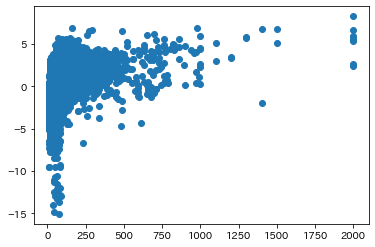

In [7]:
plt.scatter(df["面積（㎡）"], df["zscore"])
plt.show()

In [8]:
from sklearn.cluster import KMeans
pred = KMeans(n_clusters=4).fit_predict(df[["面積（㎡）", "zscore"]])	0.0771

In [9]:
df["クラスタ"] = pred

In [10]:
df.head()

,都道府県名,都道府県名_en,市区町村名,面積（㎡）,取引価格（総額）_log,zscore,クラスタ
ID,,,,,,,
1117225,北海道,1,苫小牧市,120.0,7.431364,1.231246,0
1114724,北海道,1,苫小牧市,70.0,6.342423,-1.764705,2
1114753,北海道,1,苫小牧市,70.0,6.778151,-0.565906,2
1120806,北海道,1,苫小牧市,105.0,7.230449,0.678479,0
1117264,北海道,1,苫小牧市,90.0,7.204120,0.606041,0


In [11]:
df = df[["zscore", "クラスタ"]]

In [12]:
df = pd.merge(df_b, df, on="ID")

In [13]:
df.tail()

,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,建築年,建物の構造,用途,...,容積率（％）,取引時点,改装,取引の事情等,取引価格（総額）_log,緯度,経度,都道府県名_en,zscore,クラスタ
ID,,,,,,,,,,,,,,,,,,,,,
47008534,沖縄県,うるま市,字宮里,NaN,NaN,４ＬＤＫ,65.0,10.0,ＳＲＣ,住宅,...,200.0,2019.75,未改装,NaN,7.342423,26.378685,127.857493,47,0.452388,2
47007866,沖縄県,うるま市,字江洲,NaN,NaN,３ＬＤＫ,70.0,6.0,ＲＣ,住宅,...,200.0,2018.99,改装済,NaN,7.447158,26.378685,127.857493,47,0.788960,2
47029524,沖縄県,うるま市,字塩屋,NaN,NaN,３ＬＤＫ,75.0,22.0,ＲＣ,住宅,...,100.0,2009.99,未改装,NaN,7.000000,26.378685,127.857493,47,-0.648002,0
47008285,沖縄県,うるま市,字塩屋,NaN,NaN,３ＬＤＫ,75.0,22.0,ＲＣ,住宅,...,100.0,2015.25,未改装,NaN,7.113943,26.378685,127.857493,47,-0.281840,0
47008266,沖縄県,うるま市,字塩屋,NaN,NaN,３ＬＤＫ,75.0,22.0,ＲＣ,住宅,...,NaN,2019.75,改装済,NaN,7.176091,26.378685,127.857493,47,-0.082125,0


In [14]:
area_list = set(df["市区町村名"].tolist())

In [15]:
area_class_mean = []
for area in area_list:
    area_mean = df[df["市区町村名"] == area]["クラスタ"].mean()
    area_class_mean.append(area_mean)

df_area = pd.DataFrame(area_class_mean, columns = ['クラスタ平均'])
df_area["市区町村名"] = area_list

In [16]:
df

,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,建築年,建物の構造,用途,...,容積率（％）,取引時点,改装,取引の事情等,取引価格（総額）_log,緯度,経度,都道府県名_en,zscore,クラスタ
ID,,,,,,,,,,,,,,,,,,,,,
1117225,北海道,苫小牧市,新中野町,苫小牧,25.0,３ＬＤＫ,120.0,12.0,ＲＣ,住宅,...,200.0,2018.75,未改装,NaN,7.431364,42.631246,141.603122,1,1.231246,0
1114724,北海道,苫小牧市,青葉町,青葉,9.0,３ＬＤＫ,70.0,35.0,ＲＣ,住宅,...,200.0,2017.75,未改装,NaN,6.342423,42.631246,141.603122,1,-1.764705,2
1114753,北海道,苫小牧市,青葉町,青葉,3.0,３ＬＤＫ,70.0,31.0,ＲＣ,住宅,...,200.0,2016.50,改装済,NaN,6.778151,42.631246,141.603122,1,-0.565906,2
1120806,北海道,苫小牧市,表町,苫小牧,8.0,４ＬＤＫ,105.0,18.0,ＲＣ,住宅,...,400.0,2011.99,未改装,NaN,7.230449,42.631246,141.603122,1,0.678479,0
1117264,北海道,苫小牧市,新中野町,苫小牧,25.0,３ＬＤＫ,90.0,15.0,ＲＣ,住宅,...,200.0,2015.50,未改装,NaN,7.204120,42.631246,141.603122,1,0.606041,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47008534,沖縄県,うるま市,字宮里,NaN,NaN,４ＬＤＫ,65.0,10.0,ＳＲＣ,住宅,...,200.0,2019.75,未改装,NaN,7.342423,26.378685,127.857493,47,0.452388,2
47007866,沖縄県,うるま市,字江洲,NaN,NaN,３ＬＤＫ,70.0,6.0,ＲＣ,住宅,...,200.0,2018.99,改装済,NaN,7.447158,26.378685,127.857493,47,0.788960,2
47029524,沖縄県,うるま市,字塩屋,NaN,NaN,３ＬＤＫ,75.0,22.0,ＲＣ,住宅,...,100.0,2009.99,未改装,NaN,7.000000,26.378685,127.857493,47,-0.648002,0


In [17]:
# df.groupby("都道府県名")["クラスタ平均"].mean()

In [18]:
# df_area

In [19]:
df_area.to_csv('./feature_data/area_cluster.csv', index=False)

In [20]:
df = pd.merge(df, df_area, on="市区町村名")
df["市区町村名"] = df["市区町村名"].astype("category")

In [21]:
df = df.drop("都道府県名_en", axis=1)

In [22]:
df.head()

,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,建築年,建物の構造,用途,...,容積率（％）,取引時点,改装,取引の事情等,取引価格（総額）_log,緯度,経度,zscore,クラスタ,クラスタ平均
0,北海道,苫小牧市,新中野町,苫小牧,25.0,３ＬＤＫ,120.0,12.0,ＲＣ,住宅,...,200.0,2018.75,未改装,NaN,7.431364,42.631246,141.603122,1.231246,0,0.753012
1,北海道,苫小牧市,青葉町,青葉,9.0,３ＬＤＫ,70.0,35.0,ＲＣ,住宅,...,200.0,2017.75,未改装,NaN,6.342423,42.631246,141.603122,-1.764705,2,0.753012
2,北海道,苫小牧市,青葉町,青葉,3.0,３ＬＤＫ,70.0,31.0,ＲＣ,住宅,...,200.0,2016.50,改装済,NaN,6.778151,42.631246,141.603122,-0.565906,2,0.753012
3,北海道,苫小牧市,表町,苫小牧,8.0,４ＬＤＫ,105.0,18.0,ＲＣ,住宅,...,400.0,2011.99,未改装,NaN,7.230449,42.631246,141.603122,0.678479,0,0.753012
4,北海道,苫小牧市,新中野町,苫小牧,25.0,３ＬＤＫ,90.0,15.0,ＲＣ,住宅,...,200.0,2015.50,未改装,NaN,7.204120,42.631246,141.603122,0.606041,0,0.753012


In [23]:
df = df.drop(['zscore', 'クラスタ'], axis=1)

In [24]:
df.head()

,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,建築年,建物の構造,用途,...,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等,取引価格（総額）_log,緯度,経度,クラスタ平均
0,北海道,苫小牧市,新中野町,苫小牧,25.0,３ＬＤＫ,120.0,12.0,ＲＣ,住宅,...,準工業地域,60.0,200.0,2018.75,未改装,NaN,7.431364,42.631246,141.603122,0.753012
1,北海道,苫小牧市,青葉町,青葉,9.0,３ＬＤＫ,70.0,35.0,ＲＣ,住宅,...,第１種中高層住居専用地域,60.0,200.0,2017.75,未改装,NaN,6.342423,42.631246,141.603122,0.753012
2,北海道,苫小牧市,青葉町,青葉,3.0,３ＬＤＫ,70.0,31.0,ＲＣ,住宅,...,第１種中高層住居専用地域,60.0,200.0,2016.50,改装済,NaN,6.778151,42.631246,141.603122,0.753012
3,北海道,苫小牧市,表町,苫小牧,8.0,４ＬＤＫ,105.0,18.0,ＲＣ,住宅,...,商業地域,80.0,400.0,2011.99,未改装,NaN,7.230449,42.631246,141.603122,0.753012
4,北海道,苫小牧市,新中野町,苫小牧,25.0,３ＬＤＫ,90.0,15.0,ＲＣ,住宅,...,準工業地域,60.0,200.0,2015.50,未改装,NaN,7.204120,42.631246,141.603122,0.753012


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae
import lightgbm
import optuna.integration.lightgbm as lgb


df_train, df_val = train_test_split(df, test_size=0.2)

col = "取引価格（総額）_log"
train_y = df_train[col]
train_x = df_train.drop(col, axis=1)

val_y = df_val[col]
val_x = df_val.drop(col, axis=1)

trains = lgb.Dataset(train_x, train_y)
valids = lgb.Dataset(val_x, val_y)

In [26]:
opt_params = {
    "objective":"regression",
    "metric":"mae"
}


opt=lgb.train(
    opt_params,
    trains,
    valid_sets = valids,
    verbose_eval=200,
    num_boost_round = 1000,
    early_stopping_rounds = 100
)


[I 2021-05-27 14:31:16,168] A new study created in memory with name: no-name-bbe7f3ff-1270-4d82-a74a-8f003bdc60f9
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014921 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12536
[LightGBM] [Info] Number of data points in the train set: 521580, number of used features: 20
[LightGBM] [Info] Start training from score 7.219091
Training until validation scores don't improve for 100 rounds


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[200]	valid_0's l1: 0.0783795
[400]	valid_0's l1: 0.0767798
[600]	valid_0's l1: 0.0763751
[800]	valid_0's l1: 0.0761248
[1000]	valid_0's l1: 0.0760245
Did not meet early stopping. Best iteration is:
[980]	valid_0's l1: 0.0760145


feature_fraction, val_score: 0.076015:  14%|#4        | 1/7 [00:27<02:47, 27.95s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12536
[LightGBM] [Info] Number of data points in the train set: 521580, number of used features: 20
[LightGBM] [Info] Start training from score 7.219091
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 0.0779935
[400]	valid_0's l1: 0.076401
[600]	valid_0's l1: 0.0758915
[800]	valid_0's l1: 0.075665
[1000]	valid_0's l1: 0.0755303
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.0755303


feature_fraction, val_score: 0.075530:  29%|##8       | 2/7 [00:51<02:07, 25.42s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12536
[LightGBM] [Info] Number of data points in the train set: 521580, number of used features: 20
[LightGBM] [Info] Start training from score 7.219091
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 0.0782253
[400]	valid_0's l1: 0.0766878
[600]	valid_0's l1: 0.076167
[800]	valid_0's l1: 0.0759588
[1000]	valid_0's l1: 0.0757874
Did not meet early stopping. Best iteration is:
[998]	valid_0's l1: 0.0757851


feature_fraction, val_score: 0.075530:  43%|####2     | 3/7 [01:17<01:42, 25.66s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010036 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12536
[LightGBM] [Info] Number of data points in the train set: 521580, number of used features: 20
[LightGBM] [Info] Start training from score 7.219091
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 0.0780115
[400]	valid_0's l1: 0.0761128
[600]	valid_0's l1: 0.0755882
[800]	valid_0's l1: 0.0753081
[1000]	valid_0's l1: 0.0750991
Did not meet early stopping. Best iteration is:
[990]	valid_0's l1: 0.0750976


feature_fraction, val_score: 0.075098:  57%|#####7    | 4/7 [01:41<01:15, 25.03s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12536
[LightGBM] [Info] Number of data points in the train set: 521580, number of used features: 20
[LightGBM] [Info] Start training from score 7.219091
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 0.0779551
[400]	valid_0's l1: 0.0762454
[600]	valid_0's l1: 0.0756859
[800]	valid_0's l1: 0.0754093
[1000]	valid_0's l1: 0.0752399
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.0752399


feature_fraction, val_score: 0.075098:  71%|#######1  | 5/7 [02:04<00:48, 24.16s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014540 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12536
[LightGBM] [Info] Number of data points in the train set: 521580, number of used features: 20
[LightGBM] [Info] Start training from score 7.219091
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 0.0782794
[400]	valid_0's l1: 0.0767248
[600]	valid_0's l1: 0.0762862
[800]	valid_0's l1: 0.076065
[1000]	valid_0's l1: 0.0759449
Did not meet early stopping. Best iteration is:
[996]	valid_0's l1: 0.0759439


feature_fraction, val_score: 0.075098:  86%|########5 | 6/7 [02:31<00:25, 25.30s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008649 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12536
[LightGBM] [Info] Number of data points in the train set: 521580, number of used features: 20
[LightGBM] [Info] Start training from score 7.219091
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 0.0786814
[400]	valid_0's l1: 0.0763869
[600]	valid_0's l1: 0.0758422
[800]	valid_0's l1: 0.0754625
[1000]	valid_0's l1: 0.0752364
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.0752364


num_leaves, val_score: 0.075098:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12536
[LightGBM] [Info] Number of data points in the train set: 521580, number of used features: 20
[LightGBM] [Info] Start training from score 7.219091
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 0.0756217
[400]	valid_0's l1: 0.0749486
[600]	valid_0's l1: 0.0748019
[800]	valid_0's l1: 0.0747325
[1000]	valid_0's l1: 0.0746738
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.0746738


num_leaves, val_score: 0.074674:   5%|5         | 1/20 [00:31<09:55, 31.32s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010291 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12536
[LightGBM] [Info] Number of data points in the train set: 521580, number of used features: 20
[LightGBM] [Info] Start training from score 7.219091
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 0.0748351
[400]	valid_0's l1: 0.0747278
Early stopping, best iteration is:
[305]	valid_0's l1: 0.0747031


num_leaves, val_score: 0.074674:  10%|#         | 2/20 [00:58<08:40, 28.89s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009778 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12536
[LightGBM] [Info] Number of data points in the train set: 521580, number of used features: 20
[LightGBM] [Info] Start training from score 7.219091
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 0.0753195
[400]	valid_0's l1: 0.074791
[600]	valid_0's l1: 0.0746596
Early stopping, best iteration is:
[542]	valid_0's l1: 0.0746582


num_leaves, val_score: 0.074658:  15%|#5        | 3/20 [01:25<07:54, 27.92s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010686 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12536
[LightGBM] [Info] Number of data points in the train set: 521580, number of used features: 20
[LightGBM] [Info] Start training from score 7.219091
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 0.0749809
[400]	valid_0's l1: 0.074727
Early stopping, best iteration is:
[473]	valid_0's l1: 0.0746727


num_leaves, val_score: 0.074658:  20%|##        | 4/20 [01:55<07:38, 28.68s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12536
[LightGBM] [Info] Number of data points in the train set: 521580, number of used features: 20
[LightGBM] [Info] Start training from score 7.219091
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 0.0775767
[400]	valid_0's l1: 0.0759974
[600]	valid_0's l1: 0.0754766
[800]	valid_0's l1: 0.0752211
[1000]	valid_0's l1: 0.0750616
Did not meet early stopping. Best iteration is:
[999]	valid_0's l1: 0.0750615


num_leaves, val_score: 0.074658:  25%|##5       | 5/20 [02:19<06:47, 27.15s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12536
[LightGBM] [Info] Number of data points in the train set: 521580, number of used features: 20
[LightGBM] [Info] Start training from score 7.219091
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 0.0748332
[400]	valid_0's l1: 0.074661
Early stopping, best iteration is:
[366]	valid_0's l1: 0.0746545


num_leaves, val_score: 0.074655:  30%|###       | 6/20 [02:48<06:27, 27.68s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009876 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12536
[LightGBM] [Info] Number of data points in the train set: 521580, number of used features: 20
[LightGBM] [Info] Start training from score 7.219091
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 0.0749384
Early stopping, best iteration is:
[295]	valid_0's l1: 0.0748098


num_leaves, val_score: 0.074655:  35%|###5      | 7/20 [03:13<05:49, 26.87s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009803 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12536
[LightGBM] [Info] Number of data points in the train set: 521580, number of used features: 20
[LightGBM] [Info] Start training from score 7.219091
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 0.0749882
[400]	valid_0's l1: 0.07483
Early stopping, best iteration is:
[403]	valid_0's l1: 0.0748266


num_leaves, val_score: 0.074655:  40%|####      | 8/20 [03:44<05:37, 28.16s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12536
[LightGBM] [Info] Number of data points in the train set: 521580, number of used features: 20
[LightGBM] [Info] Start training from score 7.219091
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 0.0750092
[400]	valid_0's l1: 0.0747553
Early stopping, best iteration is:
[476]	valid_0's l1: 0.0747293


num_leaves, val_score: 0.074655:  45%|####5     | 9/20 [04:12<05:10, 28.27s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009745 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12536
[LightGBM] [Info] Number of data points in the train set: 521580, number of used features: 20
[LightGBM] [Info] Start training from score 7.219091
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 0.0752955
[400]	valid_0's l1: 0.0748344
[600]	valid_0's l1: 0.0746941
[800]	valid_0's l1: 0.074655
[1000]	valid_0's l1: 0.0746083
Did not meet early stopping. Best iteration is:
[991]	valid_0's l1: 0.0746067


num_leaves, val_score: 0.074607:  50%|#####     | 10/20 [04:50<05:11, 31.11s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12536
[LightGBM] [Info] Number of data points in the train set: 521580, number of used features: 20
[LightGBM] [Info] Start training from score 7.219091
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 0.118343
[400]	valid_0's l1: 0.10755
[600]	valid_0's l1: 0.102945
[800]	valid_0's l1: 0.100257


num_leaves, val_score: 0.074607:  55%|#####5    | 11/20 [05:00<03:41, 24.61s/it]

[1000]	valid_0's l1: 0.0983673
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.0983673
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010321 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12536
[LightGBM] [Info] Number of data points in the train set: 521580, number of used features: 20
[LightGBM] [Info] Start training from score 7.219091
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 0.0749645
Early stopping, best iteration is:
[261]	valid_0's l1: 0.074863


num_leaves, val_score: 0.074607:  60%|######    | 12/20 [05:26<03:21, 25.19s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009835 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12536
[LightGBM] [Info] Number of data points in the train set: 521580, number of used features: 20
[LightGBM] [Info] Start training from score 7.219091
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 0.0751021
[400]	valid_0's l1: 0.0747272
Early stopping, best iteration is:
[484]	valid_0's l1: 0.0746795


num_leaves, val_score: 0.074607:  65%|######5   | 13/20 [05:53<03:00, 25.78s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028560 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12536
[LightGBM] [Info] Number of data points in the train set: 521580, number of used features: 20
[LightGBM] [Info] Start training from score 7.219091
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 0.0759726
[400]	valid_0's l1: 0.0751441
[600]	valid_0's l1: 0.0748576
[800]	valid_0's l1: 0.0746903
[1000]	valid_0's l1: 0.0745714
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.0745714


num_leaves, val_score: 0.074571:  70%|#######   | 14/20 [06:20<02:35, 25.92s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009622 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12536
[LightGBM] [Info] Number of data points in the train set: 521580, number of used features: 20
[LightGBM] [Info] Start training from score 7.219091
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 0.07601
[400]	valid_0's l1: 0.0751481
[600]	valid_0's l1: 0.07484
[800]	valid_0's l1: 0.0746845
[1000]	valid_0's l1: 0.0746098
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.0746098


num_leaves, val_score: 0.074571:  75%|#######5  | 15/20 [06:49<02:14, 26.85s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12536
[LightGBM] [Info] Number of data points in the train set: 521580, number of used features: 20
[LightGBM] [Info] Start training from score 7.219091
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 0.0751297
[400]	valid_0's l1: 0.0747703
[600]	valid_0's l1: 0.0746754
[800]	valid_0's l1: 0.0746465
Early stopping, best iteration is:
[810]	valid_0's l1: 0.0746424


num_leaves, val_score: 0.074571:  80%|########  | 16/20 [07:24<01:57, 29.26s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009799 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12536
[LightGBM] [Info] Number of data points in the train set: 521580, number of used features: 20
[LightGBM] [Info] Start training from score 7.219091
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 0.0784005
[400]	valid_0's l1: 0.076328
[600]	valid_0's l1: 0.0757646
[800]	valid_0's l1: 0.0754697
[1000]	valid_0's l1: 0.0752859
Did not meet early stopping. Best iteration is:
[990]	valid_0's l1: 0.0752848


num_leaves, val_score: 0.074571:  85%|########5 | 17/20 [07:48<01:23, 27.72s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009231 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12536
[LightGBM] [Info] Number of data points in the train set: 521580, number of used features: 20
[LightGBM] [Info] Start training from score 7.219091
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 0.0757526
[400]	valid_0's l1: 0.0749854
[600]	valid_0's l1: 0.0747836
[800]	valid_0's l1: 0.0746937
[1000]	valid_0's l1: 0.0745853
Did not meet early stopping. Best iteration is:
[999]	valid_0's l1: 0.0745852


num_leaves, val_score: 0.074571:  90%|######### | 18/20 [08:19<00:57, 28.80s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009822 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12536
[LightGBM] [Info] Number of data points in the train set: 521580, number of used features: 20
[LightGBM] [Info] Start training from score 7.219091
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 0.0757117
[400]	valid_0's l1: 0.0749603
[600]	valid_0's l1: 0.0747214
[800]	valid_0's l1: 0.0745919
[1000]	valid_0's l1: 0.0744931
Did not meet early stopping. Best iteration is:
[999]	valid_0's l1: 0.0744923


num_leaves, val_score: 0.074492:  95%|#########5| 19/20 [08:48<00:28, 28.86s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009988 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12536
[LightGBM] [Info] Number of data points in the train set: 521580, number of used features: 20
[LightGBM] [Info] Start training from score 7.219091
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 0.0772376
[400]	valid_0's l1: 0.075717
[600]	valid_0's l1: 0.0753222
[800]	valid_0's l1: 0.0750396
[1000]	valid_0's l1: 0.0749005
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.0749005


bagging, val_score: 0.074492:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12536
[LightGBM] [Info] Number of data points in the train set: 521580, number of used features: 20
[LightGBM] [Info] Start training from score 7.219091
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 0.077527
[400]	valid_0's l1: 0.076842
[600]	valid_0's l1: 0.0765649
[800]	valid_0's l1: 0.0763806
[1000]	valid_0's l1: 0.0763121
Did not meet early stopping. Best iteration is:
[999]	valid_0's l1: 0.0763059


bagging, val_score: 0.074492:  10%|#         | 1/10 [01:43<15:28, 103.21s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009869 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12536
[LightGBM] [Info] Number of data points in the train set: 521580, number of used features: 20
[LightGBM] [Info] Start training from score 7.219091
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 0.0760137
[400]	valid_0's l1: 0.0752681
[600]	valid_0's l1: 0.0750356
[800]	valid_0's l1: 0.074887
[1000]	valid_0's l1: 0.0748511
Did not meet early stopping. Best iteration is:
[964]	valid_0's l1: 0.0748258


bagging, val_score: 0.074492:  20%|##        | 2/10 [03:13<12:43, 95.40s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010210 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12536
[LightGBM] [Info] Number of data points in the train set: 521580, number of used features: 20
[LightGBM] [Info] Start training from score 7.219091
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 0.0758924
[400]	valid_0's l1: 0.0752394
[600]	valid_0's l1: 0.0750057
[800]	valid_0's l1: 0.0748645
[1000]	valid_0's l1: 0.074818
Did not meet early stopping. Best iteration is:
[989]	valid_0's l1: 0.0748159


bagging, val_score: 0.074492:  30%|###       | 3/10 [04:25<09:54, 84.97s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009821 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12536
[LightGBM] [Info] Number of data points in the train set: 521580, number of used features: 20
[LightGBM] [Info] Start training from score 7.219091
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 0.0758998
[400]	valid_0's l1: 0.0751616
[600]	valid_0's l1: 0.0749104
[800]	valid_0's l1: 0.0747792
[1000]	valid_0's l1: 0.0747138
Did not meet early stopping. Best iteration is:
[992]	valid_0's l1: 0.0747108


bagging, val_score: 0.074492:  40%|####      | 4/10 [05:39<08:03, 80.65s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030903 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12536
[LightGBM] [Info] Number of data points in the train set: 521580, number of used features: 20
[LightGBM] [Info] Start training from score 7.219091
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 0.0756741
[400]	valid_0's l1: 0.0749831
[600]	valid_0's l1: 0.0747652
[800]	valid_0's l1: 0.0746474
[1000]	valid_0's l1: 0.0745763
Did not meet early stopping. Best iteration is:
[997]	valid_0's l1: 0.0745744


bagging, val_score: 0.074492:  50%|#####     | 5/10 [06:20<05:31, 66.34s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010005 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12536
[LightGBM] [Info] Number of data points in the train set: 521580, number of used features: 20
[LightGBM] [Info] Start training from score 7.219091
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 0.0759209
[400]	valid_0's l1: 0.0752315
[600]	valid_0's l1: 0.0750102
[800]	valid_0's l1: 0.0748939
[1000]	valid_0's l1: 0.0747955
Did not meet early stopping. Best iteration is:
[990]	valid_0's l1: 0.0747885


bagging, val_score: 0.074492:  60%|######    | 6/10 [08:03<05:15, 78.83s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12536
[LightGBM] [Info] Number of data points in the train set: 521580, number of used features: 20
[LightGBM] [Info] Start training from score 7.219091
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 0.0774582
[400]	valid_0's l1: 0.0767635
[600]	valid_0's l1: 0.0763531
[800]	valid_0's l1: 0.0762172
[1000]	valid_0's l1: 0.0761761
Did not meet early stopping. Best iteration is:
[911]	valid_0's l1: 0.0761583


bagging, val_score: 0.074492:  70%|#######   | 7/10 [10:59<05:31, 110.47s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014875 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12536
[LightGBM] [Info] Number of data points in the train set: 521580, number of used features: 20
[LightGBM] [Info] Start training from score 7.219091
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 0.0761779
[400]	valid_0's l1: 0.0754384
[600]	valid_0's l1: 0.0751667
[800]	valid_0's l1: 0.0750352
[1000]	valid_0's l1: 0.0749918
Did not meet early stopping. Best iteration is:
[990]	valid_0's l1: 0.0749771


bagging, val_score: 0.074492:  80%|########  | 8/10 [12:53<03:43, 111.53s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017284 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12536
[LightGBM] [Info] Number of data points in the train set: 521580, number of used features: 20
[LightGBM] [Info] Start training from score 7.219091
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 0.0778769
[400]	valid_0's l1: 0.0771252
[600]	valid_0's l1: 0.0768267
[800]	valid_0's l1: 0.076643
[1000]	valid_0's l1: 0.0766412
Did not meet early stopping. Best iteration is:
[971]	valid_0's l1: 0.0765568


bagging, val_score: 0.074492:  90%|######### | 9/10 [15:31<02:06, 126.22s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017198 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12536
[LightGBM] [Info] Number of data points in the train set: 521580, number of used features: 20
[LightGBM] [Info] Start training from score 7.219091
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 0.0764013
[400]	valid_0's l1: 0.0757416
[600]	valid_0's l1: 0.0754934
[800]	valid_0's l1: 0.0753344
[1000]	valid_0's l1: 0.0752653
Did not meet early stopping. Best iteration is:
[992]	valid_0's l1: 0.0752409


feature_fraction_stage2, val_score: 0.074492:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12536
[LightGBM] [Info] Number of data points in the train set: 521580, number of used features: 20
[LightGBM] [Info] Start training from score 7.219091
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 0.0756911
[400]	valid_0's l1: 0.0750814
[600]	valid_0's l1: 0.0749363
[800]	valid_0's l1: 0.0748483
Early stopping, best iteration is:
[824]	valid_0's l1: 0.0748412


feature_fraction_stage2, val_score: 0.074492:  17%|#6        | 1/6 [00:50<04:14, 50.92s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020991 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12536
[LightGBM] [Info] Number of data points in the train set: 521580, number of used features: 20
[LightGBM] [Info] Start training from score 7.219091
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 0.0759152
[400]	valid_0's l1: 0.0751456
[600]	valid_0's l1: 0.0748685
[800]	valid_0's l1: 0.0747121
[1000]	valid_0's l1: 0.0746228
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.0746228


feature_fraction_stage2, val_score: 0.074492:  33%|###3      | 2/6 [01:39<03:17, 49.44s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017644 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12536
[LightGBM] [Info] Number of data points in the train set: 521580, number of used features: 20
[LightGBM] [Info] Start training from score 7.219091
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 0.0757117
[400]	valid_0's l1: 0.0749603
[600]	valid_0's l1: 0.0747214
[800]	valid_0's l1: 0.0745919
[1000]	valid_0's l1: 0.0744931
Did not meet early stopping. Best iteration is:
[999]	valid_0's l1: 0.0744923


feature_fraction_stage2, val_score: 0.074492:  50%|#####     | 3/6 [02:29<02:29, 49.75s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014946 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12536
[LightGBM] [Info] Number of data points in the train set: 521580, number of used features: 20
[LightGBM] [Info] Start training from score 7.219091
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 0.0761041
[400]	valid_0's l1: 0.0751139
[600]	valid_0's l1: 0.0748812
[800]	valid_0's l1: 0.0747292
[1000]	valid_0's l1: 0.0746465
Did not meet early stopping. Best iteration is:
[995]	valid_0's l1: 0.0746458


feature_fraction_stage2, val_score: 0.074492:  67%|######6   | 4/6 [03:17<01:37, 48.99s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12536
[LightGBM] [Info] Number of data points in the train set: 521580, number of used features: 20
[LightGBM] [Info] Start training from score 7.219091
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 0.0757117
[400]	valid_0's l1: 0.0749603
[600]	valid_0's l1: 0.0747214
[800]	valid_0's l1: 0.0745919
[1000]	valid_0's l1: 0.0744931
Did not meet early stopping. Best iteration is:
[999]	valid_0's l1: 0.0744923


feature_fraction_stage2, val_score: 0.074492:  83%|########3 | 5/6 [04:09<00:50, 50.33s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052655 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12536
[LightGBM] [Info] Number of data points in the train set: 521580, number of used features: 20
[LightGBM] [Info] Start training from score 7.219091
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 0.0756264
[400]	valid_0's l1: 0.075053
[600]	valid_0's l1: 0.0749175
[800]	valid_0's l1: 0.074843
[1000]	valid_0's l1: 0.0747897
Did not meet early stopping. Best iteration is:
[999]	valid_0's l1: 0.0747891


regularization_factors, val_score: 0.074492:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016870 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12536
[LightGBM] [Info] Number of data points in the train set: 521580, number of used features: 20
[LightGBM] [Info] Start training from score 7.219091
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 0.075666
[400]	valid_0's l1: 0.0749402
[600]	valid_0's l1: 0.0747033
[800]	valid_0's l1: 0.0745927
[1000]	valid_0's l1: 0.0745201
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.0745201


regularization_factors, val_score: 0.074492:   5%|5         | 1/20 [00:49<15:42, 49.58s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017439 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12536
[LightGBM] [Info] Number of data points in the train set: 521580, number of used features: 20
[LightGBM] [Info] Start training from score 7.219091
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 0.07564
[400]	valid_0's l1: 0.0748919
[600]	valid_0's l1: 0.0746796
[800]	valid_0's l1: 0.0745803
[1000]	valid_0's l1: 0.0745645
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.0745645


regularization_factors, val_score: 0.074492:  10%|#         | 2/20 [01:45<15:59, 53.32s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024536 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12536
[LightGBM] [Info] Number of data points in the train set: 521580, number of used features: 20
[LightGBM] [Info] Start training from score 7.219091
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 0.0757117
[400]	valid_0's l1: 0.0750074
[600]	valid_0's l1: 0.0747663
[800]	valid_0's l1: 0.0746301
[1000]	valid_0's l1: 0.0745707
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.0745707


regularization_factors, val_score: 0.074492:  15%|#5        | 3/20 [02:32<14:18, 50.53s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016982 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12536
[LightGBM] [Info] Number of data points in the train set: 521580, number of used features: 20
[LightGBM] [Info] Start training from score 7.219091
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 0.0756706
[400]	valid_0's l1: 0.074978
[600]	valid_0's l1: 0.0747726
[800]	valid_0's l1: 0.0746366
[1000]	valid_0's l1: 0.0745673
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.0745673


regularization_factors, val_score: 0.074492:  20%|##        | 4/20 [03:22<13:21, 50.11s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016982 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12536
[LightGBM] [Info] Number of data points in the train set: 521580, number of used features: 20
[LightGBM] [Info] Start training from score 7.219091
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 0.0757117
[400]	valid_0's l1: 0.0750074
[600]	valid_0's l1: 0.0747664
[800]	valid_0's l1: 0.0746301
[1000]	valid_0's l1: 0.0745707
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.0745707


regularization_factors, val_score: 0.074492:  25%|##5       | 5/20 [04:10<12:19, 49.33s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017140 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12536
[LightGBM] [Info] Number of data points in the train set: 521580, number of used features: 20
[LightGBM] [Info] Start training from score 7.219091
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 0.0756571
[400]	valid_0's l1: 0.0749108
[600]	valid_0's l1: 0.0747238
[800]	valid_0's l1: 0.0745963
[1000]	valid_0's l1: 0.0745326
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.0745326


regularization_factors, val_score: 0.074492:  30%|###       | 6/20 [04:58<11:26, 49.02s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017528 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12536
[LightGBM] [Info] Number of data points in the train set: 521580, number of used features: 20
[LightGBM] [Info] Start training from score 7.219091
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 0.075599
[400]	valid_0's l1: 0.0749713
[600]	valid_0's l1: 0.0747538
[800]	valid_0's l1: 0.0746494
[1000]	valid_0's l1: 0.0745776
Did not meet early stopping. Best iteration is:
[992]	valid_0's l1: 0.0745772


regularization_factors, val_score: 0.074492:  35%|###5      | 7/20 [05:47<10:36, 48.97s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015687 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12536
[LightGBM] [Info] Number of data points in the train set: 521580, number of used features: 20
[LightGBM] [Info] Start training from score 7.219091
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 0.0757053
[400]	valid_0's l1: 0.0750052
[600]	valid_0's l1: 0.0747866
[800]	valid_0's l1: 0.0746688
[1000]	valid_0's l1: 0.0746268
Did not meet early stopping. Best iteration is:
[980]	valid_0's l1: 0.0746259


regularization_factors, val_score: 0.074492:  40%|####      | 8/20 [06:35<09:42, 48.58s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016429 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12536
[LightGBM] [Info] Number of data points in the train set: 521580, number of used features: 20
[LightGBM] [Info] Start training from score 7.219091
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 0.0756736
[400]	valid_0's l1: 0.0749995
[600]	valid_0's l1: 0.0747558
[800]	valid_0's l1: 0.0746644
[1000]	valid_0's l1: 0.0746189
Did not meet early stopping. Best iteration is:
[993]	valid_0's l1: 0.0746137


regularization_factors, val_score: 0.074492:  45%|####5     | 9/20 [07:23<08:52, 48.39s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12536
[LightGBM] [Info] Number of data points in the train set: 521580, number of used features: 20
[LightGBM] [Info] Start training from score 7.219091
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 0.0756603
[400]	valid_0's l1: 0.0749507
[600]	valid_0's l1: 0.0747287
[800]	valid_0's l1: 0.0746303
[1000]	valid_0's l1: 0.0745399
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.0745399


regularization_factors, val_score: 0.074492:  50%|#####     | 10/20 [08:14<08:12, 49.27s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018790 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12536
[LightGBM] [Info] Number of data points in the train set: 521580, number of used features: 20
[LightGBM] [Info] Start training from score 7.219091
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 0.0755279
[400]	valid_0's l1: 0.0745357
[600]	valid_0's l1: 0.0742661
[800]	valid_0's l1: 0.0742067
Early stopping, best iteration is:
[809]	valid_0's l1: 0.0741953


regularization_factors, val_score: 0.074195:  55%|#####5    | 11/20 [09:19<08:07, 54.20s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017323 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12536
[LightGBM] [Info] Number of data points in the train set: 521580, number of used features: 20
[LightGBM] [Info] Start training from score 7.219091
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 0.0754843
[400]	valid_0's l1: 0.0745899
[600]	valid_0's l1: 0.0743504
[800]	valid_0's l1: 0.074341
Early stopping, best iteration is:
[747]	valid_0's l1: 0.0743355


regularization_factors, val_score: 0.074195:  60%|######    | 12/20 [10:21<07:32, 56.56s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052628 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12536
[LightGBM] [Info] Number of data points in the train set: 521580, number of used features: 20
[LightGBM] [Info] Start training from score 7.219091
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 0.0755299
[400]	valid_0's l1: 0.074414
[600]	valid_0's l1: 0.074199
Early stopping, best iteration is:
[688]	valid_0's l1: 0.0741429


regularization_factors, val_score: 0.074143:  65%|######5   | 13/20 [11:21<06:43, 57.66s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016453 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12536
[LightGBM] [Info] Number of data points in the train set: 521580, number of used features: 20
[LightGBM] [Info] Start training from score 7.219091
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 0.075464
[400]	valid_0's l1: 0.0743809
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[600]	valid_0's l1: 0.0741113
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[672]	valid_0's l1: 0.0740759


regularization_factors, val_score: 0.074076:  70%|#######   | 14/20 [12:20<05:47, 57.89s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12536
[LightGBM] [Info] Number of data points in the train set: 521580, number of used features: 20
[LightGBM] [Info] Start training from score 7.219091
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 0.0754636
[400]	valid_0's l1: 0.0745104
[600]	valid_0's l1: 0.0742661
Early stopping, best iteration is:
[652]	valid_0's l1: 0.0742201


regularization_factors, val_score: 0.074076:  75%|#######5  | 15/20 [13:18<04:50, 58.00s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016583 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12536
[LightGBM] [Info] Number of data points in the train set: 521580, number of used features: 20
[LightGBM] [Info] Start training from score 7.219091
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 0.0756583
[400]	valid_0's l1: 0.0749797
[600]	valid_0's l1: 0.0747444
[800]	valid_0's l1: 0.0746312
[1000]	valid_0's l1: 0.0745918
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.0745918


regularization_factors, val_score: 0.074076:  80%|########  | 16/20 [14:10<03:44, 56.10s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015984 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12536
[LightGBM] [Info] Number of data points in the train set: 521580, number of used features: 20
[LightGBM] [Info] Start training from score 7.219091
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 0.0756041
[400]	valid_0's l1: 0.0748743
[600]	valid_0's l1: 0.0746442
[800]	valid_0's l1: 0.0745443
Early stopping, best iteration is:
[808]	valid_0's l1: 0.0745408


regularization_factors, val_score: 0.074076:  85%|########5 | 17/20 [15:04<02:46, 55.56s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016818 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12536
[LightGBM] [Info] Number of data points in the train set: 521580, number of used features: 20
[LightGBM] [Info] Start training from score 7.219091
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 0.0755886
[400]	valid_0's l1: 0.074778
[600]	valid_0's l1: 0.0745756
[800]	valid_0's l1: 0.0744562
[1000]	valid_0's l1: 0.0744462
Did not meet early stopping. Best iteration is:
[964]	valid_0's l1: 0.0744452


regularization_factors, val_score: 0.074076:  90%|######### | 18/20 [16:03<01:52, 56.43s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015991 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12536
[LightGBM] [Info] Number of data points in the train set: 521580, number of used features: 20
[LightGBM] [Info] Start training from score 7.219091
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 0.075485
[400]	valid_0's l1: 0.0744854
[600]	valid_0's l1: 0.0741682
Early stopping, best iteration is:
[695]	valid_0's l1: 0.0740925


regularization_factors, val_score: 0.074076:  95%|#########5| 19/20 [17:02<00:57, 57.20s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12536
[LightGBM] [Info] Number of data points in the train set: 521580, number of used features: 20
[LightGBM] [Info] Start training from score 7.219091
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 0.0757117
[400]	valid_0's l1: 0.0749603
[600]	valid_0's l1: 0.0747214
[800]	valid_0's l1: 0.0745919
[1000]	valid_0's l1: 0.074493
Did not meet early stopping. Best iteration is:
[999]	valid_0's l1: 0.0744922


min_data_in_leaf, val_score: 0.074076:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016690 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12536
[LightGBM] [Info] Number of data points in the train set: 521580, number of used features: 20
[LightGBM] [Info] Start training from score 7.219091
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 0.0754512
[400]	valid_0's l1: 0.0744245
[600]	valid_0's l1: 0.074151
[800]	valid_0's l1: 0.0740585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[816]	valid_0's l1: 0.0740524


min_data_in_leaf, val_score: 0.074052:  20%|##        | 1/5 [01:07<04:31, 67.90s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016549 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12536
[LightGBM] [Info] Number of data points in the train set: 521580, number of used features: 20
[LightGBM] [Info] Start training from score 7.219091
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 0.0755986
[400]	valid_0's l1: 0.0744946
[600]	valid_0's l1: 0.0741977
Early stopping, best iteration is:
[653]	valid_0's l1: 0.0741528


min_data_in_leaf, val_score: 0.074052:  40%|####      | 2/5 [02:04<03:04, 61.50s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12536
[LightGBM] [Info] Number of data points in the train set: 521580, number of used features: 20
[LightGBM] [Info] Start training from score 7.219091
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 0.0755102
[400]	valid_0's l1: 0.07442
[600]	valid_0's l1: 0.0741892
[800]	valid_0's l1: 0.0740985
Early stopping, best iteration is:
[809]	valid_0's l1: 0.0740921


min_data_in_leaf, val_score: 0.074052:  60%|######    | 3/5 [03:13<02:09, 64.73s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016763 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12536
[LightGBM] [Info] Number of data points in the train set: 521580, number of used features: 20
[LightGBM] [Info] Start training from score 7.219091
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 0.0754951
[400]	valid_0's l1: 0.0744354
[600]	valid_0's l1: 0.0741288
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[800]	valid_0's l1: 0.0740701
Early stopping, best iteration is:
[764]	valid_0's l1: 0.0740626


min_data_in_leaf, val_score: 0.074052:  80%|########  | 4/5 [04:16<01:04, 64.04s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12536
[LightGBM] [Info] Number of data points in the train set: 521580, number of used features: 20
[LightGBM] [Info] Start training from score 7.219091
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 0.0754784
[400]	valid_0's l1: 0.074411
[600]	valid_0's l1: 0.0741004
Early stopping, best iteration is:
[672]	valid_0's l1: 0.0740512


min_data_in_leaf, val_score: 0.074051: 100%|##########| 5/5 [05:15<00:00, 63.17s/it]


In [27]:
best_params = opt.params
print(best_params)

{'objective': 'regression', 'metric': 'l1', 'feature_pre_filter': False, 'lambda_l1': 6.962531111658264, 'lambda_l2': 2.174537188320907e-05, 'num_leaves': 78, 'feature_fraction': 0.5, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 10, 'num_iterations': 1000, 'early_stopping_round': 100, 'categorical_column': [0, 1, 2, 3, 5, 8, 9, 10, 11, 15, 16]}


In [28]:
# lightGBM
import lightgbm as lgb

# params = {
#     "objective": "regression",
#     "metrics": "mae", 
#     "lambda_l1": 8.442195346804022,
#     "lambda_l2": 5.708301125509865e-05,
#     "num_leaves": 143,
#     "feature_fraction": 0.484,
#     "bagging_fraction": 1.0,
#     "bagging_freq": 0,
#     "min_child_samples": 50
# }


model = lgb.train(best_params, trains, valid_sets=valids, num_boost_round=1000, early_stopping_rounds=100, verbose_eval=200)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018631 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12536
[LightGBM] [Info] Number of data points in the train set: 521580, number of used features: 20
[LightGBM] [Info] Start training from score 7.219091
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 0.0754784
[400]	valid_0's l1: 0.074411
[600]	valid_0's l1: 0.0741004
Early stopping, best iteration is:
[672]	valid_0's l1: 0.0740512


In [29]:
vals = model.predict(val_x)
mae(vals, val_y)

0.07405119811206745

In [30]:
# import pickle
# file = '01_trained_model.pkl'
# pickle.dump(model, open(file, 'wb'))

In [31]:
df_test = pd.read_csv("/tmp/working/dataset/nishika/old_apartment_2020/test.csv", index_col=0)
df_test = data_pre2(df_test)
predict = model.predict(df_test)
df_test["取引価格（総額）_log"] = predict
df_test[["取引価格（総額）_log"]].to_csv("./output/05_sub.csv")